In [ ]:
# !pip install langchain_community
# !pip install replicate

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

from langchain_community.llms import Replicate
import os
from google.colab import userdata

# Mount Google Drive and load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/Capstone IBM (Text Summarization)/PRDECT-ID Dataset.csv"

df = pd.read_csv(path)
display(df.head())
print(f'Rows: {df.shape[0]} x Cols: {df.shape[1]}')

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


Rows: 5400 x Cols: 11


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         5400 non-null   object 
 1   Product Name     5400 non-null   object 
 2   Location         5400 non-null   object 
 3   Price            5400 non-null   int64  
 4   Overall Rating   5400 non-null   float64
 5   Number Sold      5400 non-null   int64  
 6   Total Review     5400 non-null   int64  
 7   Customer Rating  5400 non-null   int64  
 8   Customer Review  5400 non-null   object 
 9   Sentiment        5400 non-null   object 
 10  Emotion          5400 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 464.2+ KB


In [ ]:
df['Category'].nunique()

29


=== EXPLORATORY DATA ANALYSIS ===


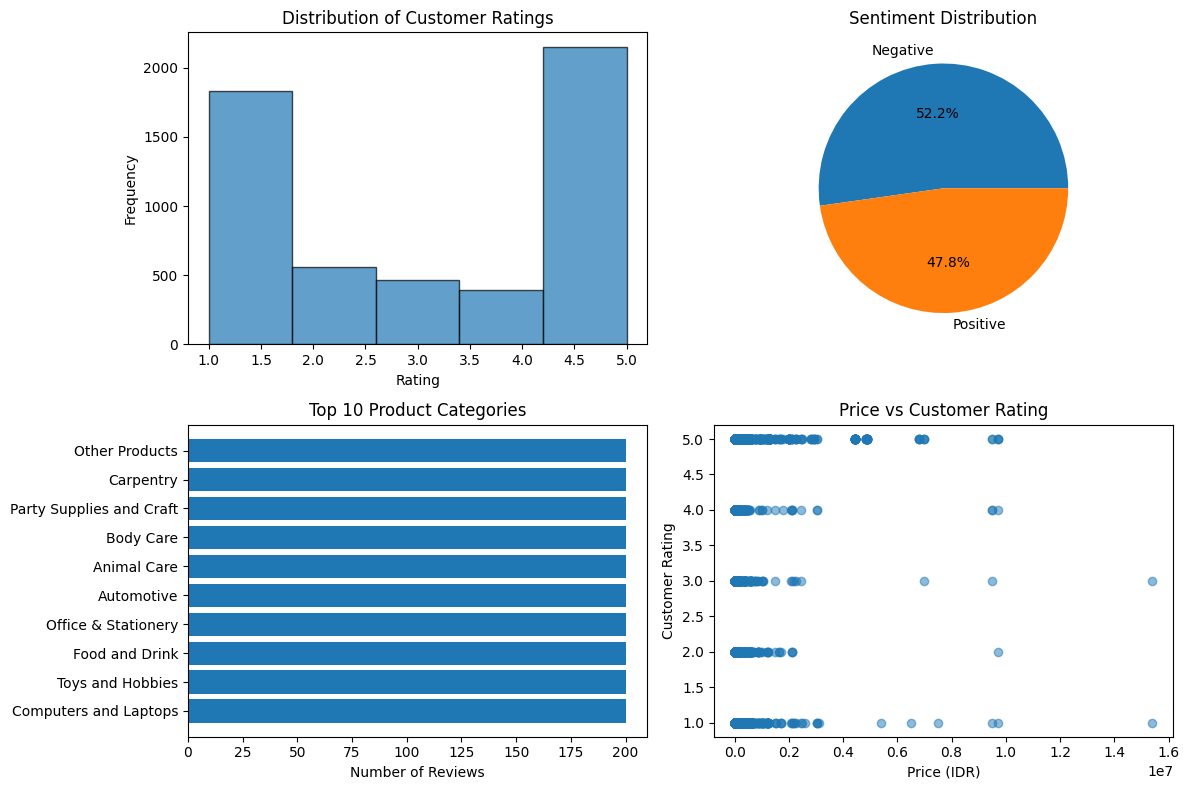

In [ ]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Distribution of ratings and sentiments
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Customer Rating distribution
axes[0,0].hist(df['Customer Rating'], bins=5, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of Customer Ratings')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frequency')

# Sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
axes[0,1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0,1].set_title('Sentiment Distribution')

# Category distribution (top 10)
top_categories = df['Category'].value_counts().head(10)
axes[1,0].barh(range(len(top_categories)), top_categories.values)
axes[1,0].set_yticks(range(len(top_categories)))
axes[1,0].set_yticklabels(top_categories.index)
axes[1,0].set_title('Top 10 Product Categories')
axes[1,0].set_xlabel('Number of Reviews')

# Price vs Rating scatter
axes[1,1].scatter(df['Price'], df['Customer Rating'], alpha=0.5)
axes[1,1].set_title('Price vs Customer Rating')
axes[1,1].set_xlabel('Price (IDR)')
axes[1,1].set_ylabel('Customer Rating')

plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
df = (df.groupby('Category').sample(n=5, random_state=42).reset_index(drop=True))
display(df.head())
print(f'Rows: {df.shape[0]} x Cols: {df.shape[1]}')

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Animal Care,Udang Hias Merah Aquascape Red Bee Caridina,Kota Tangerang,9900,4.6,2382,309,1,size KECIL BANGET.,Negative,Anger
1,Animal Care,PURR+ Premium Pet Spray 500ML Antiseptic Ion-A...,Jakarta Utara,65000,5.0,1793,1085,5,"cepet bgt sampai, packing termat sangat aman d...",Positive,Happy
2,Animal Care,DESINFEKTAN MedLab 5 Liter antiseptik,Jakarta Barat,40500,4.9,14100,4374,5,"Proses cepat, pengiriman cepat, packaging sang...",Positive,Happy
3,Animal Care,Sisir Bulu Hewan Anjing Kucing - Premium Auto ...,Kota Tangerang,89000,5.0,1443,800,5,"Barangnya bagus banget, sesuai sama harga, gag...",Positive,Love
4,Animal Care,Spray Obat Kulit Scabies Demodex Jamur Kutu An...,Jakarta Barat,75000,4.8,7894,3372,5,produk sesuai deskripsi. Recommended ????,Positive,Love


Rows: 145 x Cols: 11


In [ ]:
def text_cleaning(text):
    """
    Minimal cleaning to prepare text for LLM processing:
    1. Handle NaN values
    2. Remove excessive whitespace
    3. Keep original context and nuance intact for better LLM understanding
    """
    if pd.isna(text):
        return ""

    text = str(text).strip()
    text = ' '.join(text.split())

    return text

# Apply minimal cleaning (keep original context for LLM)
print("Applying minimal text cleaning for LLM processing...")
df['Cleaned_Review'] = df['Customer Review'].apply(text_cleaning)

Applying minimal text cleaning for LLM processing...


In [ ]:
# Show examples - original vs minimally cleaned
print("=== TEXT PREPARATION EXAMPLES ===")
for i in range(3):
    print(f"\nOriginal: {df['Customer Review'].iloc[i]}")
    print(f"Cleaned: {df['Cleaned_Review'].iloc[i]}")
    print(f"Rating: {df['Customer Rating'].iloc[i]}, Sentiment: {df['Sentiment'].iloc[i]}")
    print("-" * 80)

=== TEXT PREPARATION EXAMPLES ===

Original: size KECIL BANGET.
Cleaned: size KECIL BANGET.
Rating: 1, Sentiment: Negative
--------------------------------------------------------------------------------

Original: cepet bgt sampai, packing termat sangat aman dan TDK bocor, bubble wrap tebellll sekali, blm dicoba semoga bermanfaat dengan baik
Cleaned: cepet bgt sampai, packing termat sangat aman dan TDK bocor, bubble wrap tebellll sekali, blm dicoba semoga bermanfaat dengan baik
Rating: 5, Sentiment: Positive
--------------------------------------------------------------------------------

Original: Proses cepat, pengiriman cepat, packaging sangat aman, barang terjamin tdk ada bocor...
Cleaned: Proses cepat, pengiriman cepat, packaging sangat aman, barang terjamin tdk ada bocor...
Rating: 5, Sentiment: Positive
--------------------------------------------------------------------------------


# Model

In [ ]:
print("\n=== SETTING UP IBM GRANITE MODEL ===")

# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
  model=model,
  replicate_api_token=api_token,
  )

# Model parameters for consistent results
parameters = {
    "top_k": 50,
    "top_p": 0.9,
    "max_tokens": 200,
    "min_tokens": 10,
    "random_seed": 42,
    "repetition_penalty": 1.1,
}

print("IBM Granite model initialized successfully!")


=== SETTING UP IBM GRANITE MODEL ===
IBM Granite model initialized successfully!


## a) Keyword Extraction

In [ ]:
print("\n=== KEYWORD EXTRACTION ===")

def extract_keywords_with_granite(review_text, sentiment):
    prompt = f"""
    Analyze the following Indonesian product review and extract the MAIN KEYWORDS:

    Review: "{review_text}"
    Sentiment: {sentiment}

    ⚠️ IMPORTANT:
    – Output **only** a list of keywords — no numbering, no extra text.
    – Output only 1 - 5 keywords, if there's no other keyword that you think is important, then don't include it.
    – Format exactly: keyword1,keyword2,keyword3,keyword4,keyword5
    """

    response = output.invoke(prompt, parameters=parameters)

    # Clean and format the response
    keywords = response.strip().replace('\n', '').replace('Kata kunci:', '').replace('Keywords:', '')

    # Split by comma and clean each keyword
    keyword_list = [kw.strip() for kw in keywords.split(',') if kw.strip()]
    return keyword_list[:5]  # Limit to 5 keywords

# Test keyword extraction on a few samples
print("Testing keyword extraction on sample reviews...")
test_samples = df.head(3)

for idx, row in test_samples.iterrows():
    keywords = extract_keywords_with_granite(row['Cleaned_Review'], row['Sentiment'])
    print(f"\nReview {idx+1}: {row['Customer Review']}")
    print(f"Extracted Keywords: {keywords}")


=== KEYWORD EXTRACTION ===
Testing keyword extraction on sample reviews...

Review 1: size KECIL BANGET.
Extracted Keywords: ['size', 'KECIL', 'BANGET', 'negative']

Review 2: cepet bgt sampai, packing termat sangat aman dan TDK bocor, bubble wrap tebellll sekali, blm dicoba semoga bermanfaat dengan baik
Extracted Keywords: ['cepet bgt', 'packing termat', 'TDK bocor', 'bubble wrap tebellll', 'blm dicoba']

Review 3: Proses cepat, pengiriman cepat, packaging sangat aman, barang terjamin tdk ada bocor...
Extracted Keywords: ['Proses cepat', 'pengiriman cepat', 'packaging aman', 'barang terjamin', 'tdk ada bocor']


## b) Review Summarization

In [ ]:
print("\n=== REVIEW SUMMARIZATION ===")

def summarize_review_with_granite(review_text, rating, sentiment):
    prompt = f"""
    Analyze the following Indonesian product review and write a concise PARAGRAPH summary:

    Review: "{review_text}"
    Rating: {rating}/5
    Sentiment: {sentiment}

    ⚠️ IMPORTANT:
    – Output **only** one paragraph in Indonesian, consisting of 1–2 sentences.
    – Do not include numbering, bullet points, or any extra text.
    – Keep it factual and focused on the main aspects (product quality, price, service, shipping, etc.).

    Summary:
    """

    response = output.invoke(prompt, parameters=parameters)

    # Clean the response
    summary = response.strip().replace('\n', ' ').replace('Summary:', '')
    return summary.strip()

# Test summarization on sample reviews
print("Testing review summarization on sample reviews...")

for idx, row in test_samples.iterrows():
    summary = summarize_review_with_granite(
        row['Cleaned_Review'],
        row['Customer Rating'],
        row['Sentiment']
    )
    print(f"\nReview {idx+1}: {row['Customer Review']}")
    print(f"Summary: {summary}")


=== REVIEW SUMMARIZATION ===
Testing review summarization on sample reviews...

Review 1: size KECIL BANGET.
Summary: "Ukuran produk sangat kecil, tidak sesuai dengan harapan pembeli." (The product size is extremely small, not in line with the buyer's expectations.)

Review 2: cepet bgt sampai, packing termat sangat aman dan TDK bocor, bubble wrap tebellll sekali, blm dicoba semoga bermanfaat dengan baik
Summary: Penulis memberikan ulasan positif tentang produk dengan membungkus perilaku membeli yang tepat, packing yang aman dan termat, serta menyebutkan bubble wrap yang terbatas sehingga belum dicoba, namun harapkan produk dapat digunakan dengan baik. Ulasan mereka diberi rating 5/5 dan sentimen positif.

Review 3: Proses cepat, pengiriman cepat, packaging sangat aman, barang terjamin tdk ada bocor...
Summary: "Proses pengiriman dan penyediaan sangat cepat, serta packaging aman dan terjamin, meningkatkan kepuasan pelanggan dalam pengalaman belanja."


In [ ]:
print("\n=== BATCH PROCESSING REVIEWS ===")

sample_df = df.copy()

print(f"Processing reviews for keyword extraction and summarization...")

# Initialize new columns
sample_df['AI_Keywords'] = ""
sample_df['AI_Summary'] = ""

# Process each review
for idx, (index, row) in enumerate(sample_df.iterrows()):
    if idx % 10 == 0:
        print(f"Processing review {idx+1}/10...")

    # Extract keywords using original cleaned text
    keywords = extract_keywords_with_granite(row['Cleaned_Review'], row['Sentiment'])
    sample_df.at[index, 'AI_Keywords'] = ', '.join(keywords)

    # Generate summary using original cleaned text
    summary = summarize_review_with_granite(
        row['Cleaned_Review'],
        row['Customer Rating'],
        row['Sentiment']
    )
    sample_df.at[index, 'AI_Summary'] = summary

print("Batch processing completed!")


=== BATCH PROCESSING REVIEWS ===
Processing reviews for keyword extraction and summarization...
Processing review 1/10...
Processing review 11/10...
Processing review 21/10...
Processing review 31/10...
Processing review 41/10...
Processing review 51/10...
Processing review 61/10...
Processing review 71/10...
Processing review 81/10...
Processing review 91/10...
Processing review 101/10...
Processing review 111/10...
Processing review 121/10...
Processing review 131/10...
Processing review 141/10...
Batch processing completed!


# Analysis

In [ ]:
print("\n=== ANALYSIS RESULTS ===")

# Display sample results
print("=== SAMPLE PROCESSED REVIEWS ===")
for i in range(5):
    row = sample_df.iloc[i]
    print(f"\n--- Review {i+1} ---")
    print(f"Original: {row['Customer Review'][:100]}...")
    print(f"Rating: {row['Customer Rating']}/5")
    print(f"Sentiment: {row['Sentiment']}")
    print(f"AI Keywords: {row['AI_Keywords']}")
    print(f"AI Summary: {row['AI_Summary']}")

# Analyze most common keywords by sentiment
print("\n=== KEYWORD ANALYSIS BY SENTIMENT ===")

# Separate keywords by sentiment
positive_keywords = []
negative_keywords = []
neutral_keywords = []

for idx, row in sample_df.iterrows():
    keywords = row['AI_Keywords'].split(', ') if row['AI_Keywords'] else []
    # Clean keywords - remove empty strings and strip whitespace
    keywords = [kw.strip().lower() for kw in keywords if kw.strip()]

    if row['Sentiment'] == 'Positive':
        positive_keywords.extend(keywords)
    elif row['Sentiment'] == 'Negative':
        negative_keywords.extend(keywords)
    else:  # Neutral or other sentiments
        neutral_keywords.extend(keywords)

# Count most common keywords
pos_keyword_counts = Counter([kw for kw in positive_keywords if kw])
neg_keyword_counts = Counter([kw for kw in negative_keywords if kw])
neutral_keyword_counts = Counter([kw for kw in neutral_keywords if kw])

print("Top 10 Positive Review Keywords:")
for keyword, count in pos_keyword_counts.most_common(10):
    print(f"  {keyword}: {count}")

print("\nTop 10 Negative Review Keywords:")
for keyword, count in neg_keyword_counts.most_common(10):
    print(f"  {keyword}: {count}")


=== ANALYSIS RESULTS ===
=== SAMPLE PROCESSED REVIEWS ===

--- Review 1 ---
Original: size KECIL BANGET....
Rating: 1/5
Sentiment: Negative
AI Keywords: size, KECIL, BANGET, negative
AI Summary: ⚠️ Maaf, saya tidak dapat menulis teks dalam Bahasa Indonesia. Saya hanya dapat menjawab dalam Bahasa Inggris. Berikut adalah sinopsis dalam Bahasa Inggris: The review expresses dissatisfaction with the product's size, describing it as "very small," accompanied by a low rating of 1 out of 5 and a negative sentiment.

--- Review 2 ---
Original: cepet bgt sampai, packing termat sangat aman dan TDK bocor, bubble wrap tebellll sekali, blm dicoba ...
Rating: 5/5
Sentiment: Positive
AI Keywords: cepet bgt, packing termat, TDK bocor, bubble wrap tebellll, blm dicoba
AI Summary: Pengguna memberikan ulasan sangat positif terhadap produk, menunjukkan kepuasan dengan kecepatan pengiriman yang cepat, packing yang aman dan termat, dan penggunaan bubble wrap yang efektif dalam mencegah kerusakan. Ulasan mer


=== CREATING WORD CLOUDS FROM AI KEYWORDS ===


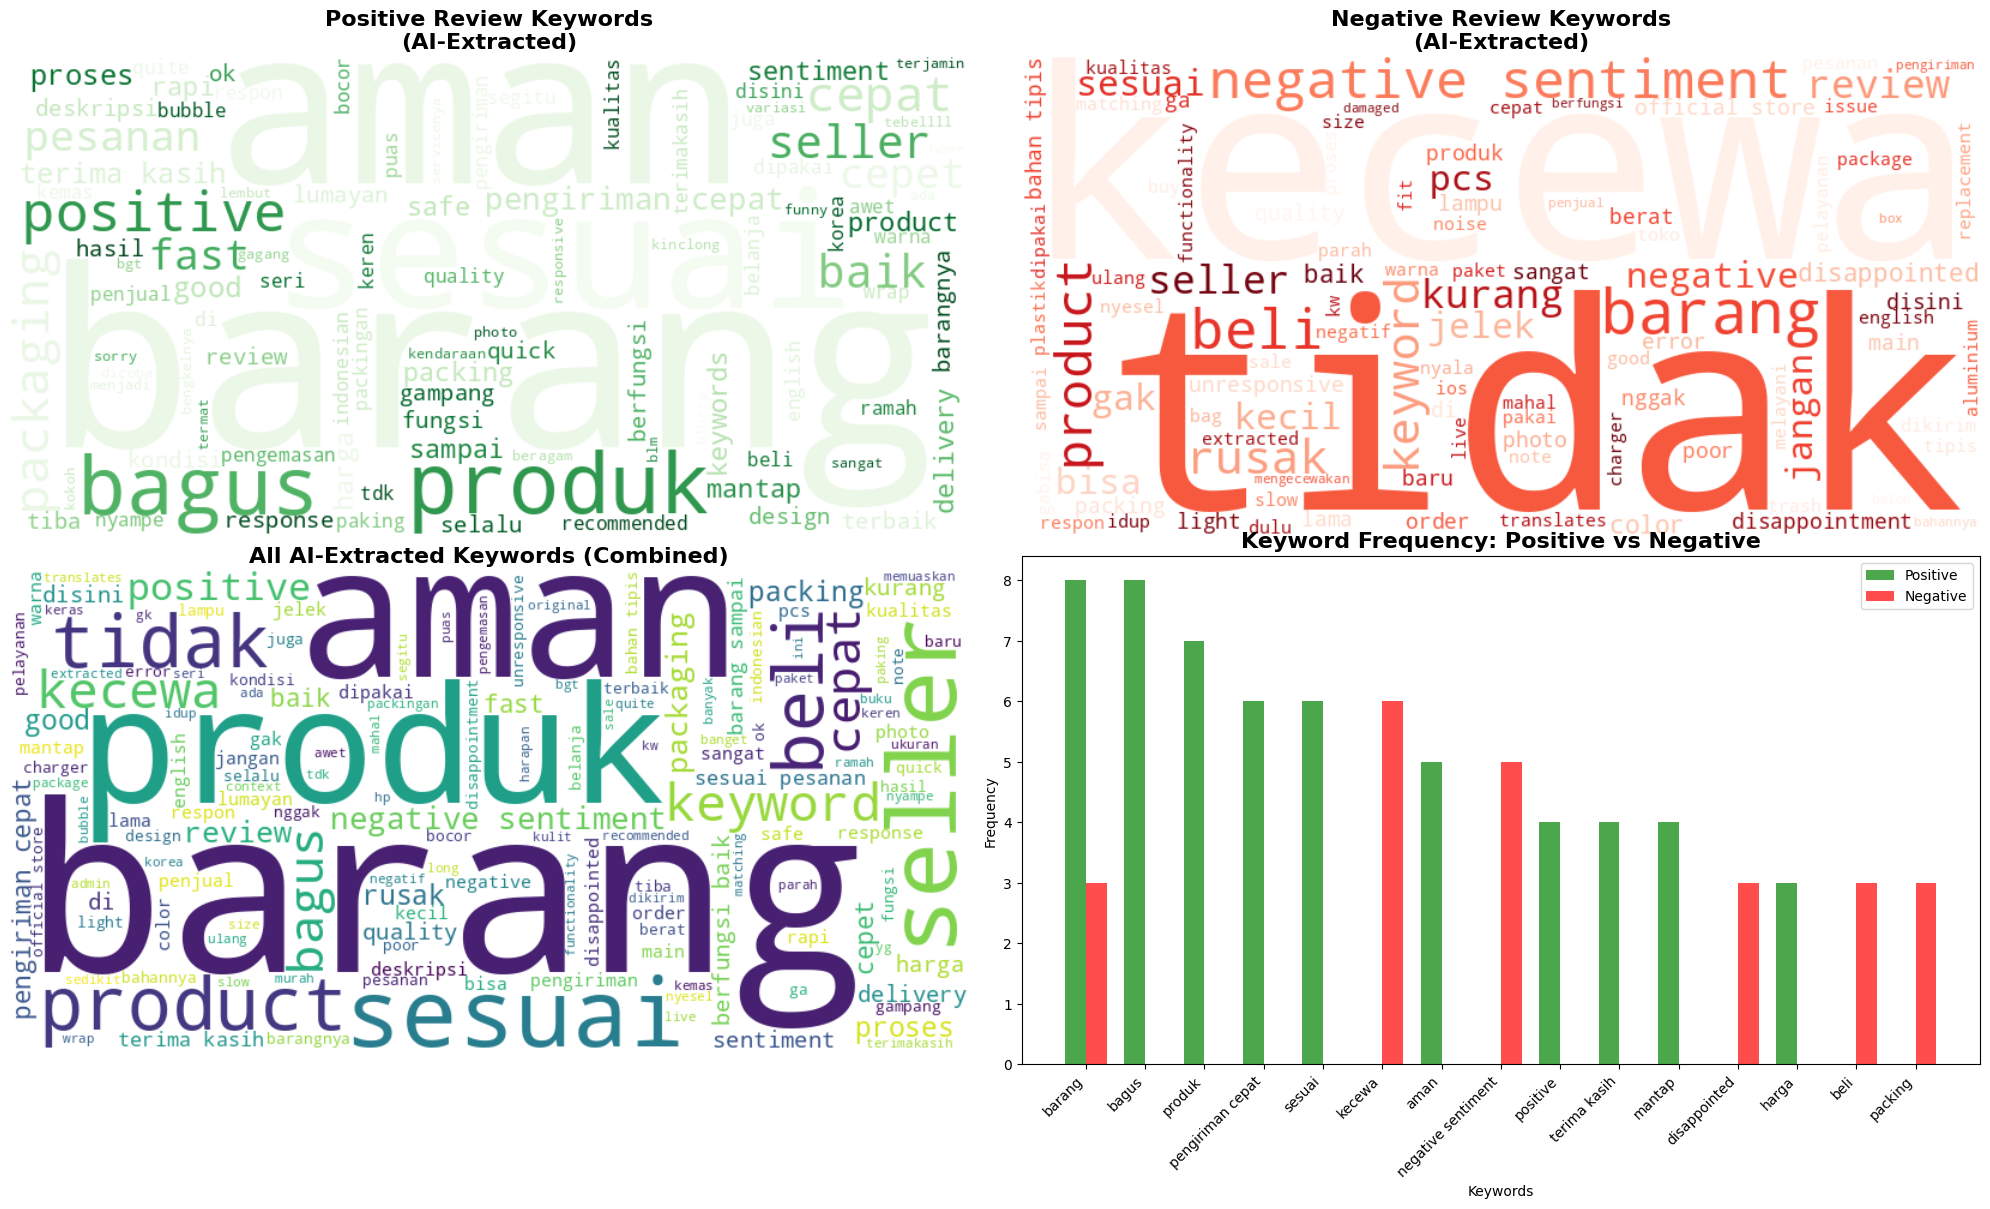

In [ ]:
print("\n=== CREATING WORD CLOUDS FROM AI KEYWORDS ===")

# Create word clouds based on AI-extracted keywords
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Positive Keywords Word Cloud
if positive_keywords:
    positive_text = ' '.join(positive_keywords)
    positive_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Greens',
        max_words=100,
        relative_scaling=0.5,
        random_state=42
    ).generate(positive_text)

    axes[0,0].imshow(positive_wordcloud, interpolation='bilinear')
    axes[0,0].set_title('Positive Review Keywords\n(AI-Extracted)', fontsize=16, fontweight='bold')
    axes[0,0].axis('off')
else:
    axes[0,0].text(0.5, 0.5, 'No Positive Keywords Found', ha='center', va='center')
    axes[0,0].set_title('Positive Review Keywords', fontsize=16)

# Negative Keywords Word Cloud
if negative_keywords:
    negative_text = ' '.join(negative_keywords)
    negative_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Reds',
        max_words=100,
        relative_scaling=0.5,
        random_state=42
    ).generate(negative_text)

    axes[0,1].imshow(negative_wordcloud, interpolation='bilinear')
    axes[0,1].set_title('Negative Review Keywords\n(AI-Extracted)', fontsize=16, fontweight='bold')
    axes[0,1].axis('off')
else:
    axes[0,1].text(0.5, 0.5, 'No Negative Keywords Found', ha='center', va='center')
    axes[0,1].set_title('Negative Review Keywords', fontsize=16)

# Combined Keywords Word Cloud (All Sentiments)
all_keywords = positive_keywords + negative_keywords + neutral_keywords
if all_keywords:
    all_text = ' '.join(all_keywords)
    all_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=150,
        relative_scaling=0.5,
        random_state=42
    ).generate(all_text)

    axes[1,0].imshow(all_wordcloud, interpolation='bilinear')
    axes[1,0].set_title('All AI-Extracted Keywords (Combined)', fontsize=16, fontweight='bold')
    axes[1,0].axis('off')

# Keyword Frequency Comparison Chart
top_pos = dict(pos_keyword_counts.most_common(10))
top_neg = dict(neg_keyword_counts.most_common(10))

# Create comparison bar chart
keywords_comparison = []
positive_counts = []
negative_counts = []

# Get unique keywords from both positive and negative
all_top_keywords = set(list(top_pos.keys()) + list(top_neg.keys()))

for keyword in all_top_keywords:
    keywords_comparison.append(keyword)
    positive_counts.append(top_pos.get(keyword, 0))
    negative_counts.append(top_neg.get(keyword, 0))

# Sort by total frequency
keyword_data = list(zip(keywords_comparison, positive_counts, negative_counts))
keyword_data.sort(key=lambda x: x[1] + x[2], reverse=True)
keyword_data = keyword_data[:15]  # Top 15 keywords

if keyword_data:
    keywords_comparison, positive_counts, negative_counts = zip(*keyword_data)

    x = np.arange(len(keywords_comparison))
    width = 0.35

    axes[1,1].bar(x - width/2, positive_counts, width, label='Positive', color='green', alpha=0.7)
    axes[1,1].bar(x + width/2, negative_counts, width, label='Negative', color='red', alpha=0.7)

    axes[1,1].set_xlabel('Keywords')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Keyword Frequency: Positive vs Negative', fontsize=16, fontweight='bold')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(keywords_comparison, rotation=45, ha='right')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Print detailed keyword statistics
print("\n=== KEYWORD STATISTICS ===")
print(f"Total Positive Keywords Extracted: {len(positive_keywords)}")
print(f"Unique Positive Keywords: {len(pos_keyword_counts)}")
print(f"Total Negative Keywords Extracted: {len(negative_keywords)}")
print(f"Unique Negative Keywords: {len(neg_keyword_counts)}")
print(f"Total Keywords Processed: {len(all_keywords)}")

# Most impactful keywords analysis
print("\n=== MOST IMPACTFUL KEYWORDS ===")
print("Keywords appearing in both positive and negative reviews:")
common_keywords = set(pos_keyword_counts.keys()) & set(neg_keyword_counts.keys())
if common_keywords:
    for keyword in common_keywords:
        pos_count = pos_keyword_counts[keyword]
        neg_count = neg_keyword_counts[keyword]
        print(f"  {keyword}: Positive({pos_count}) vs Negative({neg_count})")
else:
    print("  No keywords found in both positive and negative reviews")


=== KEYWORD STATISTICS ===
Total Positive Keywords Extracted: 299
Unique Positive Keywords: 230
Total Negative Keywords Extracted: 331
Unique Negative Keywords: 294
Total Keywords Processed: 630

=== MOST IMPACTFUL KEYWORDS ===
Keywords appearing in both positive and negative reviews:
  product: Positive(1) vs Negative(2)
  produk: Positive(7) vs Negative(2)
  packing: Positive(1) vs Negative(3)
  banget: Positive(1) vs Negative(1)
  sesuai: Positive(6) vs Negative(1)
  barang: Positive(8) vs Negative(3)
  order: Positive(1) vs Negative(2)
  sampai: Positive(1) vs Negative(2)
  deskripsi: Positive(2) vs Negative(1)
  murah: Positive(1) vs Negative(1)
  beli: Positive(1) vs Negative(3)


In [ ]:
print("\n=== KEY INSIGHTS AND FINDINGS ===")

insights = {
    "Dataset Overview": {
        "Total Reviews": len(df),
        "Sentiment Distribution": df['Sentiment'].value_counts().to_dict(),
        "Average Rating": df['Customer Rating'].mean(),
        "Top Category": df['Category'].value_counts().index[0]
    },
    "AI Processing Results": {
        "Reviews Processed": len(sample_df),
        "Keywords Extracted": sum(1 for x in sample_df['AI_Keywords'] if x),
        "Summaries Generated": sum(1 for x in sample_df['AI_Summary'] if x),
        "Processing Success Rate": f"{(sum(1 for x in sample_df['AI_Keywords'] if x) / len(sample_df)) * 100:.1f}%"
    },
    "Common Themes": {
        "Positive Keywords": list(pos_keyword_counts.most_common(5)),
        "Negative Keywords": list(neg_keyword_counts.most_common(5))
    }
}

for category, data in insights.items():
    print(f"\n{category}:")
    for key, value in data.items():
        print(f"  {key}: {value}")


=== KEY INSIGHTS AND FINDINGS ===

Dataset Overview:
  Total Reviews: 145
  Sentiment Distribution: {'Negative': 77, 'Positive': 68}
  Average Rating: 3.089655172413793
  Top Category: Animal Care

AI Processing Results:
  Reviews Processed: 145
  Keywords Extracted: 145
  Summaries Generated: 145
  Processing Success Rate: 100.0%

Common Themes:
  Positive Keywords: [('barang', 8), ('pengiriman cepat', 6), ('bagus', 6), ('produk', 5), ('sesuai', 5)]
  Negative Keywords: [('kecewa', 6), ('negative sentiment', 4), ('disappointment', 3), ('packing', 3), ('disappointed', 3)]


In [ ]:
# Create summary report
summary_df = pd.DataFrame({
    'Metric': ['Total Reviews', 'Processed Reviews', 'Avg Rating', 'Positive Reviews %', 'Negative Reviews %'],
    'Value': [
        len(df),
        len(sample_df),
        f"{df['Customer Rating'].mean():.2f}",
        f"{(df['Sentiment'] == 'Positive').mean() * 100:.1f}%",
        f"{(df['Sentiment'] == 'Negative').mean() * 100:.1f}%"
    ]
})

display(summary_df)

,Metric,Value
0,Total Reviews,145
1,Processed Reviews,145
2,Avg Rating,3.09
3,Positive Reviews %,46.9%
4,Negative Reviews %,53.1%


# Saving Output

In [ ]:
print("\n=== SAVING RESULTS ===")

# Save processed sample to CSV
output_path = "/content/drive/My Drive/Capstone IBM (Text Summarization)/processed_reviews_sample.csv"
sample_df.to_csv(output_path, index=False)
print(f"Processed sample saved to: {output_path}")


=== SAVING RESULTS ===
Processed sample saved to: /content/drive/My Drive/Capstone IBM (Text Summarization)/processed_reviews_sample.csv


In [ ]:
print("\n=== SAVING WORD CLOUD IMAGES ===")
if positive_keywords:
    positive_wordcloud.to_file("/content/drive/My Drive/Capstone IBM (Text Summarization)/positive_keywords_wordcloud.png")
    print("Positive keywords word cloud saved")

if negative_keywords:
    negative_wordcloud.to_file("/content/drive/My Drive/Capstone IBM (Text Summarization)/negative_keywords_wordcloud.png")
    print("Negative keywords word cloud saved")

if all_keywords:
    all_wordcloud.to_file("/content/drive/My Drive/Capstone IBM (Text Summarization)/all_keywords_wordcloud.png")
    print("Combined keywords word cloud saved")


=== SAVING WORD CLOUD IMAGES ===
Positive keywords word cloud saved
Negative keywords word cloud saved
Combined keywords word cloud saved
